# Analyse arbitrage data we have

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Install stuff

In [2]:
!pip install pandas

You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
!pip install matplotlib

You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
!pip install sqlalchemy

You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
!pip install boto3

You should consider upgrading via the 'pip install --upgrade pip' command.


In [6]:
import sys
import os
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import boto3

In [7]:
matplotlib.style.use('seaborn')

In [8]:
aws_access_key = os.environ["GIW_AWS_ACCESS_KEY"]
aws_access_secret = os.environ["GIW_AWS_ACCESS_SECRET"]
print()

In [9]:
boto3.setup_default_session(profile_name="goodit")

## Load data

In [10]:
table = boto3.resource("dynamodb").Table("patron-arbitrage")

In [11]:
response = table.scan()
data = response['Items']

In [12]:
len(data)

3173

In [13]:
data[:5]

[{'roi': Decimal('0.001756636192973171'),
  'profit': Decimal('1.416366979213303'),
  'market_path': 'EPS/BTC -> BTC/USDT -> EPS/USDT',
  'market': 'EPS/BTC',
  'coin_path': 'EPS -> BTC -> USDT -> EPS',
  'timems': Decimal('1620561473483')},
 {'roi': Decimal('0.002334603798706425'),
  'profit': Decimal('1.7051946145751729'),
  'market_path': 'HOT/BUSD -> BNB/BUSD -> HOT/BNB',
  'market': 'HOT/BUSD',
  'coin_path': 'HOT -> BUSD -> BNB -> HOT',
  'timems': Decimal('1620644621758')},
 {'roi': Decimal('0.009234737201892718'),
  'profit': Decimal('24.12021009762359'),
  'market_path': 'HOT/BUSD -> BUSD/TRY -> HOT/TRY',
  'market': 'HOT/BUSD',
  'coin_path': 'HOT -> BUSD -> TRY -> HOT',
  'timems': Decimal('1620644622511')},
 {'roi': Decimal('0.007878453474585267'),
  'profit': Decimal('3.4554896939530986'),
  'market_path': 'HOT/BUSD -> BUSD/TRY -> HOT/TRY',
  'market': 'HOT/BUSD',
  'coin_path': 'HOT -> BUSD -> TRY -> HOT',
  'timems': Decimal('1620644623980')},
 {'roi': Decimal('0.0051547

In [14]:
df = pd.DataFrame(data)

In [15]:
df.head()

,roi,profit,market_path,market,coin_path,timems
0,0.001756636192973171,1.416366979213303,EPS/BTC -> BTC/USDT -> EPS/USDT,EPS/BTC,EPS -> BTC -> USDT -> EPS,1620561473483
1,0.002334603798706425,1.7051946145751729,HOT/BUSD -> BNB/BUSD -> HOT/BNB,HOT/BUSD,HOT -> BUSD -> BNB -> HOT,1620644621758
2,0.009234737201892718,24.12021009762359,HOT/BUSD -> BUSD/TRY -> HOT/TRY,HOT/BUSD,HOT -> BUSD -> TRY -> HOT,1620644622511
3,0.007878453474585267,3.4554896939530986,HOT/BUSD -> BUSD/TRY -> HOT/TRY,HOT/BUSD,HOT -> BUSD -> TRY -> HOT,1620644623980
4,0.005154715529422926,7.065053104627062,HOT/BUSD -> BUSD/TRY -> HOT/TRY,HOT/BUSD,HOT -> BUSD -> TRY -> HOT,1620644624637


In [16]:
starttime, endtime = min(df.timems), max(df.timems)

In [17]:
starttime = pd.to_datetime(int(starttime), unit="ms")
endtime = pd.to_datetime(int(endtime), unit="ms")

In [18]:
df["end_market"] = df["market_path"].apply(lambda s: s.split(" -> ")[2])

In [19]:
def find_base_coin(start_market: str, end_market: str) -> str:
    coins_s = start_market.split("/")
    coins_e = end_market.split("/")
    if coins_s[0] == coins_e[0] or coins_s[0] == coins_e[1]:
        return coins_s[0]
    if coins_s[1] == coins_e[0] or coins_s[1] == coins_e[1]:
        return coins_s[1]
    raise AttributeError(f"No match between '{start_market}' and '{end_market}'")
    

In [20]:
df["coin"] = df.apply(lambda x: find_base_coin(x.market, x.end_market), axis=1)

In [21]:
len(df)

3173

In [22]:
df["profit"] = df.profit.apply(float)
df["roi"] = df.roi.apply(float)

## Total Profit

In [23]:
df_by_coin = df[["profit", "coin"]].groupby("coin").sum()

In [24]:
df_avg_by_coin = df.groupby("coin").mean()

In [25]:
df_counts_by_coin = df[["market", "coin"]].groupby("coin").count().rename(columns={"market": "arbitrage_count"})

In [26]:
df_by_coin = df_by_coin.merge(df_avg_by_coin, how="inner", on="coin", suffixes=["_total", "_avg"])

In [27]:
df_by_coin = df_by_coin.merge(df_counts_by_coin, how="inner", on="coin").reset_index()

In [28]:
df_by_coin.head()

,coin,profit_total,roi,profit_avg,arbitrage_count
0,1INCH,3.639619,0.002571,0.202201,18
1,ACM,0.003592,0.003070,0.003592,1
2,ADA,162.867913,0.007616,2.544811,64
3,ALGO,12.776478,0.001466,0.456303,28
4,ATM,0.000650,0.000197,0.000650,1


## Convert all to USD

In [29]:
# load tickers from S3
s3 = boto3.client('s3')
obj = s3.get_object(Bucket='goodit-patron-atrbitrage', Key='bidasks_20210508.json')
df_prices = pd.read_json(obj['Body']).T

In [30]:
df_prices_usd = df_prices.query("Market.str.contains('USDT') or Market.str.contains('BUSD') or Market.str.contains('USDC')")

In [31]:
def _get_coin_not_usdx(market: str) -> str:
    coins = market.split("/")
    return coins[0] if "USD" in coins[1] else coins[1]

In [32]:
def _get_coin_not_usdx_side(market: str) -> str:
    coins = market.split("/")
    return "BUY" if "USD" in coins[1] else "SELL"

In [33]:
df_prices_usd["coin"] = df_prices_usd["Market"].apply(_get_coin_not_usdx)

/Users/az/.pyenv/versions/3.7.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [34]:
df_prices_usd["side"] = df_prices_usd["Market"].apply(_get_coin_not_usdx_side)

/Users/az/.pyenv/versions/3.7.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## Total Profit

In [35]:
def _get_price_in_usd(coin: str) -> float:
    if "USD" in coin:
        return 1
    row_dicts = df_prices_usd[df_prices_usd.coin == coin].to_dict(orient='records')
    if len(row_dicts) == 0:
        print(f"Didn't find for {coin}")
        return 0
    row_dict = row_dicts[0]
    if row_dict["side"] == "BUY":
        return float(row_dict["BestBid"])
    else:
        return 1 / float(row_dict["BestAsk"])

In [36]:
df_by_coin["price_usd"] = df_by_coin.coin.apply(_get_price_in_usd)

Didn't find for ELF
Didn't find for QLC
Didn't find for QSP


In [37]:
df_by_coin["profit_usd"] = df_by_coin.profit_total * df_by_coin.price_usd

In [38]:
df_by_coin.head()

,coin,profit_total,roi,profit_avg,arbitrage_count,price_usd,profit_usd
0,1INCH,3.639619,0.002571,0.202201,18,7.2330,26.325364
1,ACM,0.003592,0.003070,0.003592,1,10.4420,0.037507
2,ADA,162.867913,0.007616,2.544811,64,1.6008,260.718955
3,ALGO,12.776478,0.001466,0.456303,28,1.5358,19.622115
4,ATM,0.000650,0.000197,0.000650,1,10.2880,0.006689


In [39]:
df_by_coin_top10 = df_by_coin.sort_values("profit_usd", ascending=False)[:10]
df_by_coin_top10

,coin,profit_total,roi,profit_avg,arbitrage_count,price_usd,profit_usd
20,DOGE,8855.698186,0.008779,17.854230,496,0.720380,6379.467859
66,USDT,4334.891175,0.008964,10.272254,422,1.000000,4334.891175
14,BUSD,1750.673391,0.009483,4.987673,351,1.000000,1750.673391
13,BTC,0.028196,0.009043,0.000082,344,58900.000000,1660.728956
27,EUR,1333.245801,0.010261,9.323397,143,1.209800,1612.960771
6,AUD,1641.126708,0.007091,19.772611,83,0.775900,1273.350212
61,TRY,8754.012476,0.007388,51.193055,171,0.120656,1056.227374
54,RVN,4850.286753,0.018063,808.381126,6,0.176100,854.135497
26,ETH,0.181727,0.007954,0.000707,257,3563.950000,647.664477
31,GBP,349.655902,0.008831,4.113599,85,1.387200,485.042667


In [40]:
all_coins_total_profit = sum(df_by_coin.profit_usd)
all_coins_total_profit

21994.256114300006

In [41]:
top10_coins_total_profit = sum(df_by_coin_top10.profit_usd)
top10_coins_total_profit

20055.142379692992

<AxesSubplot:xlabel='coin'>

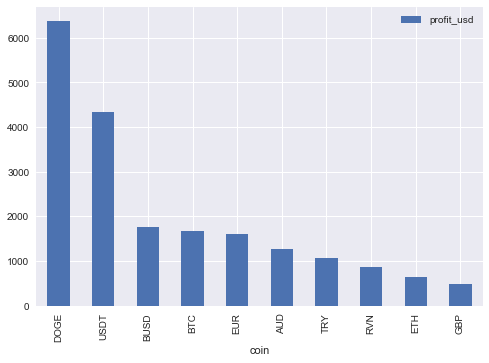

In [42]:
df_by_coin_top10.plot.bar(x="coin", y="profit_usd")

## Stable Coins Profit

In [43]:
df_by_coin_stable = df_by_coin.query("coin.str.contains('BTC') or coin.str.contains('ETH') or coin.str.contains('EUR') or coin.str.contains('RUB') or coin.str.contains('USD')")

In [44]:
df_by_coin_stable = df_by_coin_stable.sort_values("profit_usd", ascending=False)
df_by_coin_stable

,coin,profit_total,roi,profit_avg,arbitrage_count,price_usd,profit_usd
66,USDT,4334.891175,0.008964,10.272254,422,1.000000,4334.891175
14,BUSD,1750.673391,0.009483,4.987673,351,1.000000,1750.673391
13,BTC,0.028196,0.009043,0.000082,344,58900.000000,1660.728956
27,EUR,1333.245801,0.010261,9.323397,143,1.209800,1612.960771
26,ETH,0.181727,0.007954,0.000707,257,3563.950000,647.664477
53,RUB,14226.312371,0.005079,169.360862,84,0.013479,191.757705
65,USDC,36.742205,0.008214,3.674220,10,1.000000,36.742205
62,TUSD,3.096637,0.003757,0.774159,4,1.000000,3.096637


In [45]:
stable_coints_total_profit = sum(df_by_coin_stable.profit_usd)
stable_coints_total_profit

10238.51531650528

<AxesSubplot:xlabel='coin'>

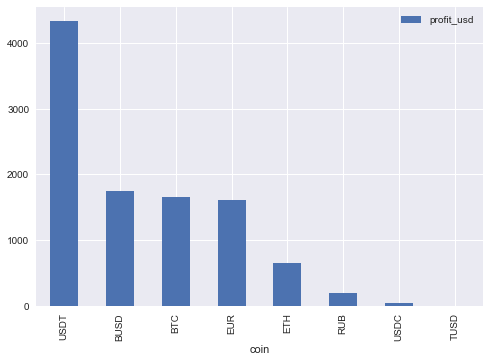

In [46]:
df_by_coin_stable.plot.bar(x="coin", y="profit_usd")

## Resume

In [50]:
print(f"""
    ALL Coins total profit: \t$ {round(all_coins_total_profit)}
    TOP10 Coins total profit: \t$ {round(top10_coins_total_profit)}
    Stable Coins total profit: \t$ {round(stable_coints_total_profit)}
    Best Coin '{df_by_coin_top10.iloc[0].coin}' profit: \t$ {round(df_by_coin_top10.iloc[0].profit_total)}
    Best Stable '{df_by_coin_stable.iloc[0].coin}' profit: \t$ {round(df_by_coin_stable.iloc[0].profit_total)}
    ----------------
    First Arbitrage Time: \t{starttime}
    Last Arbitrage Time: \t{endtime}
""")


    ALL Coins total profit: 	$ 21994
    TOP10 Coins total profit: 	$ 20055
    Stable Coins total profit: 	$ 10239
    Best Coin 'DOGE' profit: 	$ 8856
    Best Stable 'USDT' profit: 	$ 4335
    ----------------
    First Arbitrage Time: 	2021-05-08 17:22:35.320000
    Last Arbitrage Time: 	2021-05-10 21:20:26.535000

